In [6]:
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas
import pandas as pd
import seaborn as sns
import yaml
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.datasets import make_circles, make_blobs, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree


SEED = 314159
TRAIN_TEST_SPLIT = 0.80

data_path = r"D:\data\machine_learning"

# Решающие деревья

Решающее дерево предсказывает значение целевой переменной с помощью применения последовательности простых правил. И хотя обобщающая способность решающих деревьев невелика, его все равно часто используют из-за легкой интерпретации. К тому же, решающие деревья успешно объединяются в ансамбли, что решает часть проблем.

В целом, решающие деревья (в основном как части ансамблей) довольно успешно используются. Вопрос: какие еще есть плюсы у решающих деревьев?

Однако решающие деревья также требуют аккуратности. Какая самая простая проблема приходит на ум?
Эту и другие сложности рассмотрим в этом ноутбуке.


Рассмотрим набор данных о качестве вина на основе различных химических показателей. Есть всего 6 значений качества, поэтому задачу проще всего решать классификацией.

In [7]:
df = pd.read_csv(data_path+'/'+"winequality-red.csv")

In [8]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


# Разделяющие поверхности

Рассмотрим то, как дерево решений строит разделяющие поверхности. Для начала снова получим обучающие и тестовые данные.

In [66]:
df_major = df[df["quality"].isin([5,6])]
print("Length of filtered data is", len(df_major))
X = df_major.drop('quality', axis=1)
y = df_major['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

Length of filtered data is 1319


Воспользуемся встроенным функционалом scikit-learn. К сожалению, он позволяет строить только модели для двух входных переменных, поэтому выберем пару переменных поинформативнее.

In [26]:
# Choosing the first 2 columns for the plot
features = ['volatile acidity', 'alcohol' ]
X_train_cols = X_train.loc[:, features ]
# Creating and fitting the tree classifier
classifier = DecisionTreeClassifier(random_state=SEED).fit(X_train_cols, y_train)


In [18]:
def plot_boundary(
        classifier, data: pd.DataFrame, features: list[str], y: pd.DataFrame | pd.Series | None = None
) -> None:
    # Plotting the tree boundaries
    disp = DecisionBoundaryDisplay.from_estimator(
        classifier,
        data.loc[:, features],
        response_method="predict_proba",
        xlabel=features[0], ylabel=features[1],
        alpha=0.5,
        cmap=plt.cm.coolwarm,
        grid_resolution=500
    )

    # Plotting the data points
    # your code. You can use disp.ax_ to access the axis
    disp.ax_.scatter(
        data.loc[:, features[0]], data.loc[:, features[1]], c=y, edgecolor="k",cmap=plt.cm.coolwarm
    )
    plt.title(f"Decision surface for {classifier.__class__.__name__} trained on {features[0]} and {features[1]}")
    plt.show()

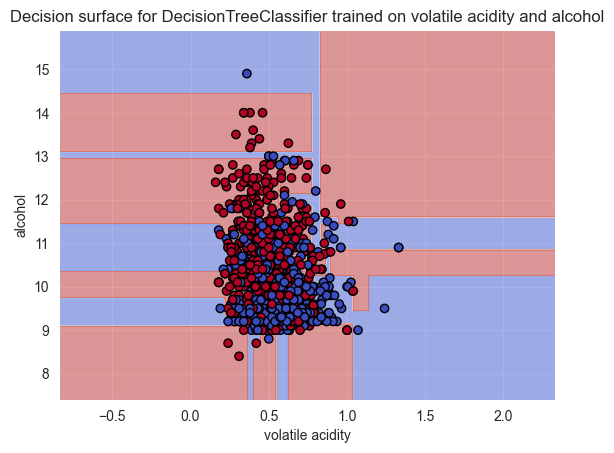

In [25]:
 plot_boundary(classifier, data=X_train, features=features, y=y_train)

Отличается ли поверхность для тестового множества?

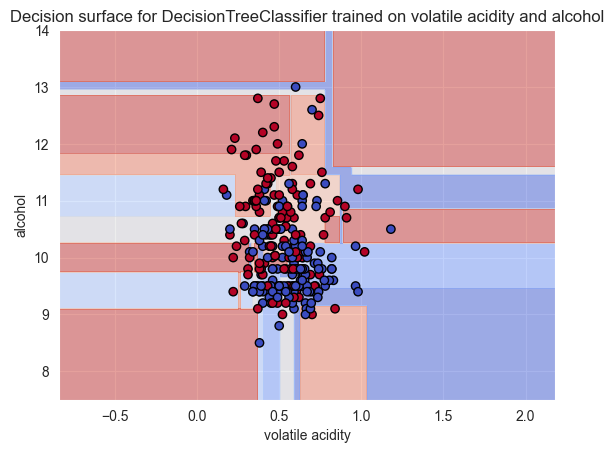

In [23]:
X_test_cols = X_test.loc[:, features ]
plot_boundary(classifier, data=X_test_cols, features=features, y=y_test)

На таком графике может быть хорошо заметно влияние даже одного примера на принятие решения.

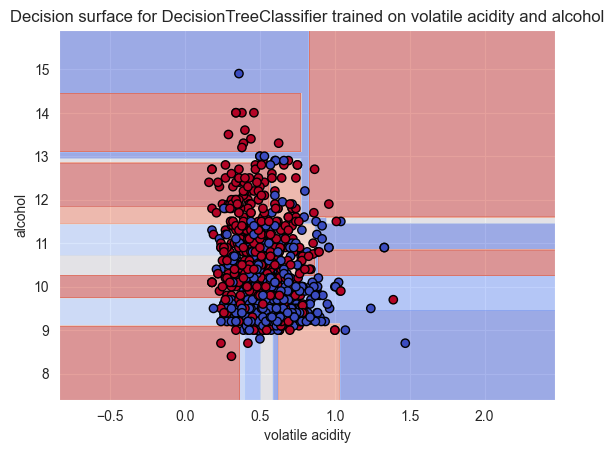

In [27]:
# Choosing the first 2 columns for the plot
features = ['volatile acidity', 'alcohol' ]
X_train_cols = X_train.copy()[:][features]
X_train_cols.loc[768, 'volatile acidity'] += 0.8
X_train_cols.loc[71, 'volatile acidity'] += 0.8
X_train_cols.loc[71, 'alcohol'] -= 0.8
# change one sample
# Creating and fitting the tree classifier
classifier_new = DecisionTreeClassifier(max_depth=6,
                                    random_state=SEED).fit(X_train_cols, y_train)

plot_boundary(classifier_new, X_train_cols, features, y_train)

Решающие деревья часто совмещают с PCA. Это мешает интерпретируемости, но часто достаточно полезно.

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # your code
X_train_pca = pd.DataFrame(pca.fit_transform(X_train), columns=["x1", "x2"]) # your code
X_test_pca = pd.DataFrame(pca.transform(X_test), columns=["x1", "x2"]) # your code

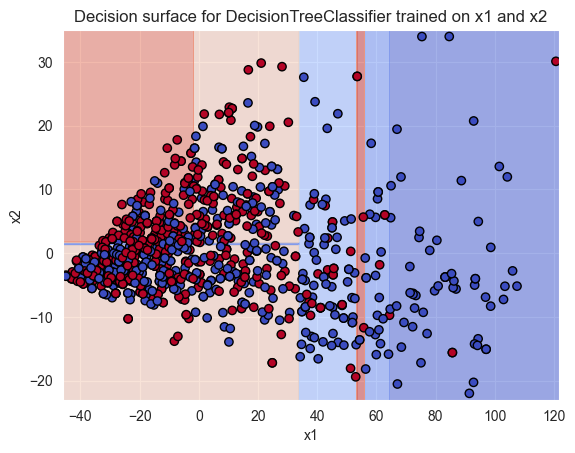

In [44]:
features = ["x1", "x2"]
classifier = DecisionTreeClassifier(random_state=SEED, max_depth=3, min_samples_split=5, min_samples_leaf=5).fit(X_train_pca, y_train)

plot_boundary(classifier, X_train_pca, features, y_train)

In [38]:
classifier.get_depth()

6

Train accuracy: 0.590521327014218
Test accuracy: 0.6401515151515151
Depth:  2
Number of leaves:  3


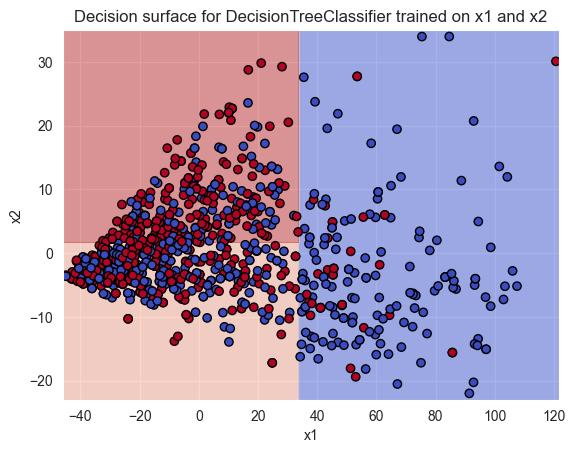

In [54]:
features = ["x1", "x2"]
classifier = DecisionTreeClassifier(random_state=SEED, ccp_alpha=0.005).fit(X_train_pca, y_train)
print("Train accuracy:", classifier.score(X_train_pca, y_train))
print("Test accuracy:", classifier.score(X_test_pca, y_test))
print("Depth: ", classifier.get_depth())
print("Number of leaves: ", classifier.get_n_leaves())
plot_boundary(classifier, X_train_pca, features, y_train)

Train accuracy: 0.7298578199052133
Test accuracy: 0.5984848484848485
Depth:  13
Number of leaves:  163


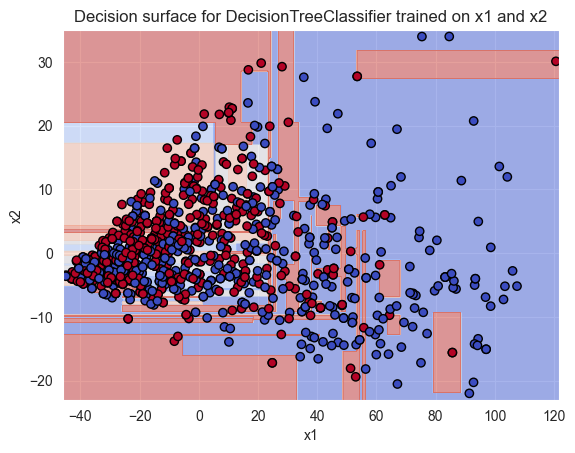

In [56]:
features = ["x1", "x2"]
classifier = DecisionTreeClassifier(random_state=SEED, max_depth=13, splitter="random").fit(X_train_pca, y_train)
print("Train accuracy:", classifier.score(X_train_pca, y_train))
print("Test accuracy:", classifier.score(X_test_pca, y_test))
print("Depth: ", classifier.get_depth())
print("Number of leaves: ", classifier.get_n_leaves())
plot_boundary(classifier, X_train_pca, features, y_train)

Как видно, границы принятия решений довольно "хаотичны", что говорит о явном переобучении. Давайте оценим, как будут влиять на них различные гиперпараметры.

Для начала рассмотрим глубину дерева.

In [ ]:
# your code - change max depth of the tree and plot the boundaries

In [ ]:
# your code - change max depth of the tree and plot the boundaries

In [ ]:
# your code - change other parameters of the tree and plot the boundaries

Каким будет оптимальный набор гиперпараметров?

In [94]:
from sklearn.model_selection import GridSearchCV
params = {
    "max_depth": [1,4,5,10,15,20],
    #"min_impurity_decrease": [0.005, 0.003, 0.001],
    "min_samples_leaf": [5, 10, 20, 30, 50]
}

In [95]:
classifier = DecisionTreeClassifier(random_state=SEED)
grid_search = GridSearchCV(estimator=classifier,
                           param_grid=params,
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy").fit(X_train_pca, y_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


In [98]:
grid_search.best_params_

{'max_depth': 5, 'min_samples_leaf': 50}

Train accuracy: 0.6369668246445498
Test accuracy: 0.625
Depth:  5
Number of leaves:  13


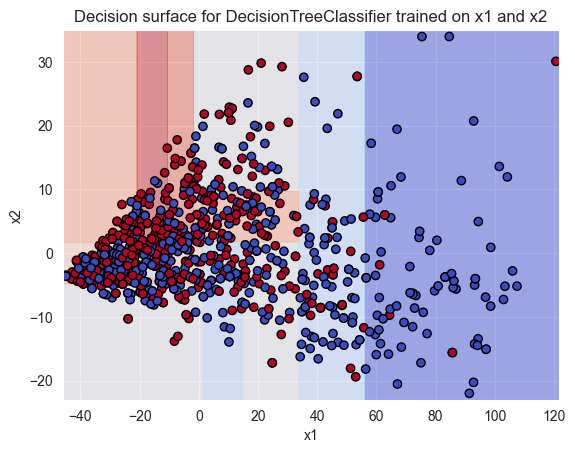

In [97]:
features = ["x1", "x2"]
classifier = DecisionTreeClassifier(random_state=SEED, **grid_search.best_params_).fit(X_train_pca, y_train)
print("Train accuracy:", classifier.score(X_train_pca, y_train))
print("Test accuracy:", classifier.score(X_test_pca, y_test))
print("Depth: ", classifier.get_depth())
print("Number of leaves: ", classifier.get_n_leaves())
plot_boundary(classifier, X_train_pca, features, y_train)

In [ ]:
# run grid search for previosly fixed depth. Can we achieve similar results using that setting?

In [ ]:
# plot the decision boundary

Другая опция, как можно автоматизировать подбор гиперпараметров - Randomized Search. В отличие от Grid Search, этот метод выбирает параметры не по сетке, а случайно. Причем показано, что при равном бютжете на оптимизацию гиперпараметров он работает даже лучше, чем Grid Search. Посмотрим, будет ли выбор разный.

In [105]:
from sklearn.model_selection import GridSearchCV
params = {
    "max_depth": [1,4,5,10,15,20],
    "min_impurity_decrease": [0.005, 0.003, 0.001, 0.0005, 0.0001],
    "min_samples_leaf": [5, 10, 20, 30, 50]
}

In [106]:
from sklearn.model_selection import RandomizedSearchCV
classifier = DecisionTreeClassifier(random_state=SEED)
grid_search = RandomizedSearchCV(estimator=classifier,
                           param_distributions=params,
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy").fit(X_train_pca, y_train)


Fitting 4 folds for each of 10 candidates, totalling 40 fits


In [108]:
grid_search.best_params_

{'min_samples_leaf': 30, 'min_impurity_decrease': 0.0005, 'max_depth': 5}

Train accuracy: 0.633175355450237
Test accuracy: 0.5984848484848485
Depth:  5
Number of leaves:  16


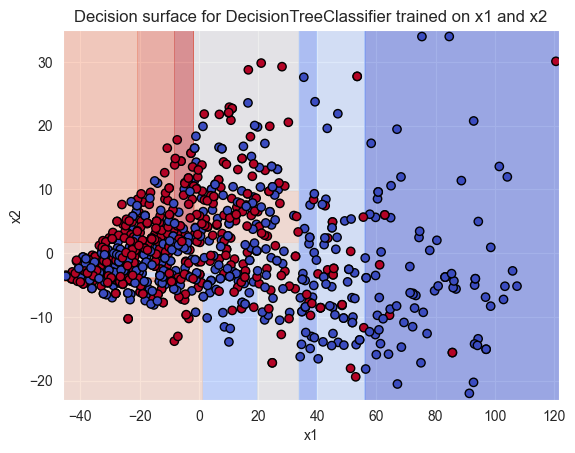

In [107]:
features = ["x1", "x2"]
classifier = DecisionTreeClassifier(random_state=SEED, **grid_search.best_params_).fit(X_train_pca, y_train)
print("Train accuracy:", classifier.score(X_train_pca, y_train))
print("Test accuracy:", classifier.score(X_test_pca, y_test))
print("Depth: ", classifier.get_depth())
print("Number of leaves: ", classifier.get_n_leaves())
plot_boundary(classifier, X_train_pca, features, y_train)

Рассмотрим и важность выбора сплиттера. Так, DecisionTree позволяет выбирать между random и best. Random отличается тем, что вместо проверки всех возможных порогов разделения по признаку проверяется один случайный порог, взятый из равномерного распределенния между минимумом и максимумом признака.

In [58]:
X_gen, y_gen = make_classification(n_samples=500, n_features=2000, n_informative=600,
                           n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,
                           class_sep=0.9, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_gen, y_gen, test_size=0.2, random_state=SEED)

In [61]:
classifier = DecisionTreeClassifier(min_samples_leaf=5,
                                    random_state=SEED).fit(X_train, y_train)
print("Importances", np.sort(classifier.feature_importances_))
print("Depth", classifier.get_depth())
print("Num leaves", classifier.get_n_leaves())
print("Train score is: ", classifier.score(X_train, y_train))
print("Test score is: ", classifier.score(X_test, y_test))

Importances [0.         0.         0.         ... 0.05811152 0.06200111 0.06379778]
Depth 8
Num leaves 30
Train score is:  0.945
Test score is:  0.56


In [62]:
classifier = DecisionTreeClassifier(min_samples_leaf=5,
                                    random_state=SEED, splitter="random").fit(X_train, y_train)
print("Importances", np.sort(classifier.feature_importances_))
print("Depth", classifier.get_depth())
print("Num leaves", classifier.get_n_leaves())
print("Train score is: ", classifier.score(X_train, y_train))
print("Test score is: ", classifier.score(X_test, y_test))

Importances [0.         0.         0.         ... 0.04614757 0.04622039 0.04625794]
Depth 14
Num leaves 43
Train score is:  0.9225
Test score is:  0.55
